## **Mounting Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing Required Libraries**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## **Reading CSV Files to Pandas Dataframes**

In [5]:
crypto_df = pd.read_csv('/content/drive/MyDrive/Crypto/train.csv')
a_df = pd.read_csv('/content/drive/MyDrive/Crypto/asset_details.csv')

In [35]:
crypto_df.head(5)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


# **Exploratory Analysis**

**Checking Correlation between different assets**

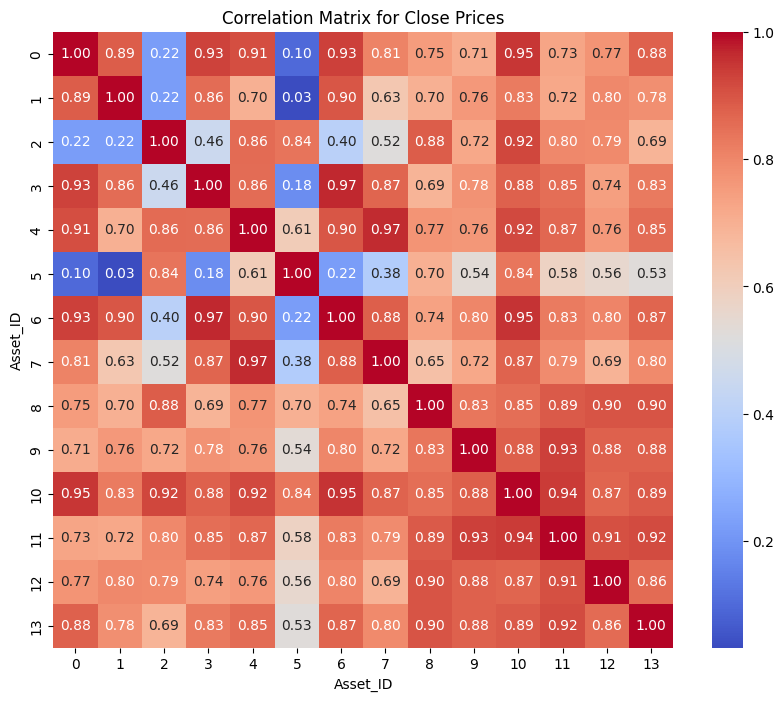

In [50]:
df1 = crypto_df.copy()
# Convert the 'Date' column to datetime
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

# Set the 'Date' column as the index
df1.set_index('timestamp', inplace=True)

# Calculate the correlation matrix for the 'Close' prices
close_corr = df1.pivot(columns='Asset_ID', values='Close').corr()

# Assuming close_corr is the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(close_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Close Prices')
plt.show()

In [40]:
# Selecting Data for Bitcoin, Etherium & Cardano - Highly correlated
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp")
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp")
car = crypto_df[crypto_df["Asset_ID"]==3].set_index("timestamp")

**Checking for Null Values**

In [41]:
btc.isnull().sum()
eth.isnull().sum()
car.isnull().sum()

Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target      18731
dtype: int64

**Filling Null values with Moving averages**

In [42]:
moving_avg_btc = btc['Target'].rolling(window=1000, min_periods=1).mean()
# Fill NaN values in the specified column with moving average
btc['Target'] = btc['Target'].fillna(moving_avg_btc)
moving_avg_eth = eth['Target'].rolling(window=1000, min_periods=1).mean()
# Fill NaN values in the specified column with moving average
eth['Target'] = eth['Target'].fillna(moving_avg_eth)
moving_avg_car = car['Target'].rolling(window=1000, min_periods=1).mean()
# Fill NaN values in the specified column with moving average
car['Target'] = car['Target'].fillna(moving_avg_eth)

**Checking for Missing Records**

In [43]:
(btc.index[1:]-btc.index[:-1]).value_counts().head()
(eth.index[1:]-eth.index[:-1]).value_counts().head()
(car.index[1:]-car.index[:-1]).value_counts().head()

60     1782506
120       7848
180       1090
240        270
300         79
Name: timestamp, dtype: int64

**Imputing missing records using forward fill**

In [44]:
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
car = car.reindex(range(car.index[0],car.index[-1]+60,60),method='pad')

In [45]:
# Preprocessing
btc.reset_index(drop=False, inplace=True)
btc['timestamp'] = pd.to_datetime(btc['timestamp'], unit='s')
btc.set_index('timestamp', inplace=True)
eth.reset_index(drop=False, inplace=True)
eth['timestamp'] = pd.to_datetime(eth['timestamp'], unit='s')
eth.set_index('timestamp', inplace=True)
car.reset_index(drop=False, inplace=True)
car['timestamp'] = pd.to_datetime(car['timestamp'], unit='s')
car.set_index('timestamp', inplace=True)

**Resampling data to select data for every 15 minutes**

In [94]:
btc_resampled = btc.resample('15T').last()
eth_resampled = eth.resample('15T').last()
car_resampled = car.resample('15T').last()

**Checking Price trend**

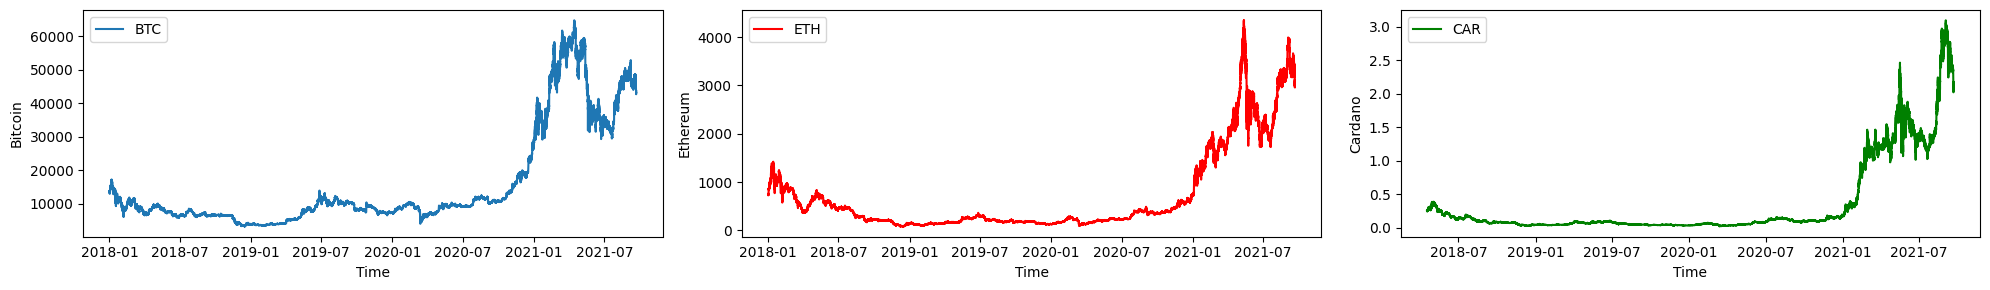

In [49]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(20, 3))

ax = f.add_subplot(131)  # Change 121 to 131
plt.plot(btc_resampled['Close'], label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(132)  # Change 122 to 132
ax2.plot(eth_resampled['Close'], color='red', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

ax3 = f.add_subplot(133)  # Add a new subplot
ax3.plot(car_resampled['Close'], color='green', label='CAR')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cardano')

plt.tight_layout()
plt.show()

**Checking distribution of features**

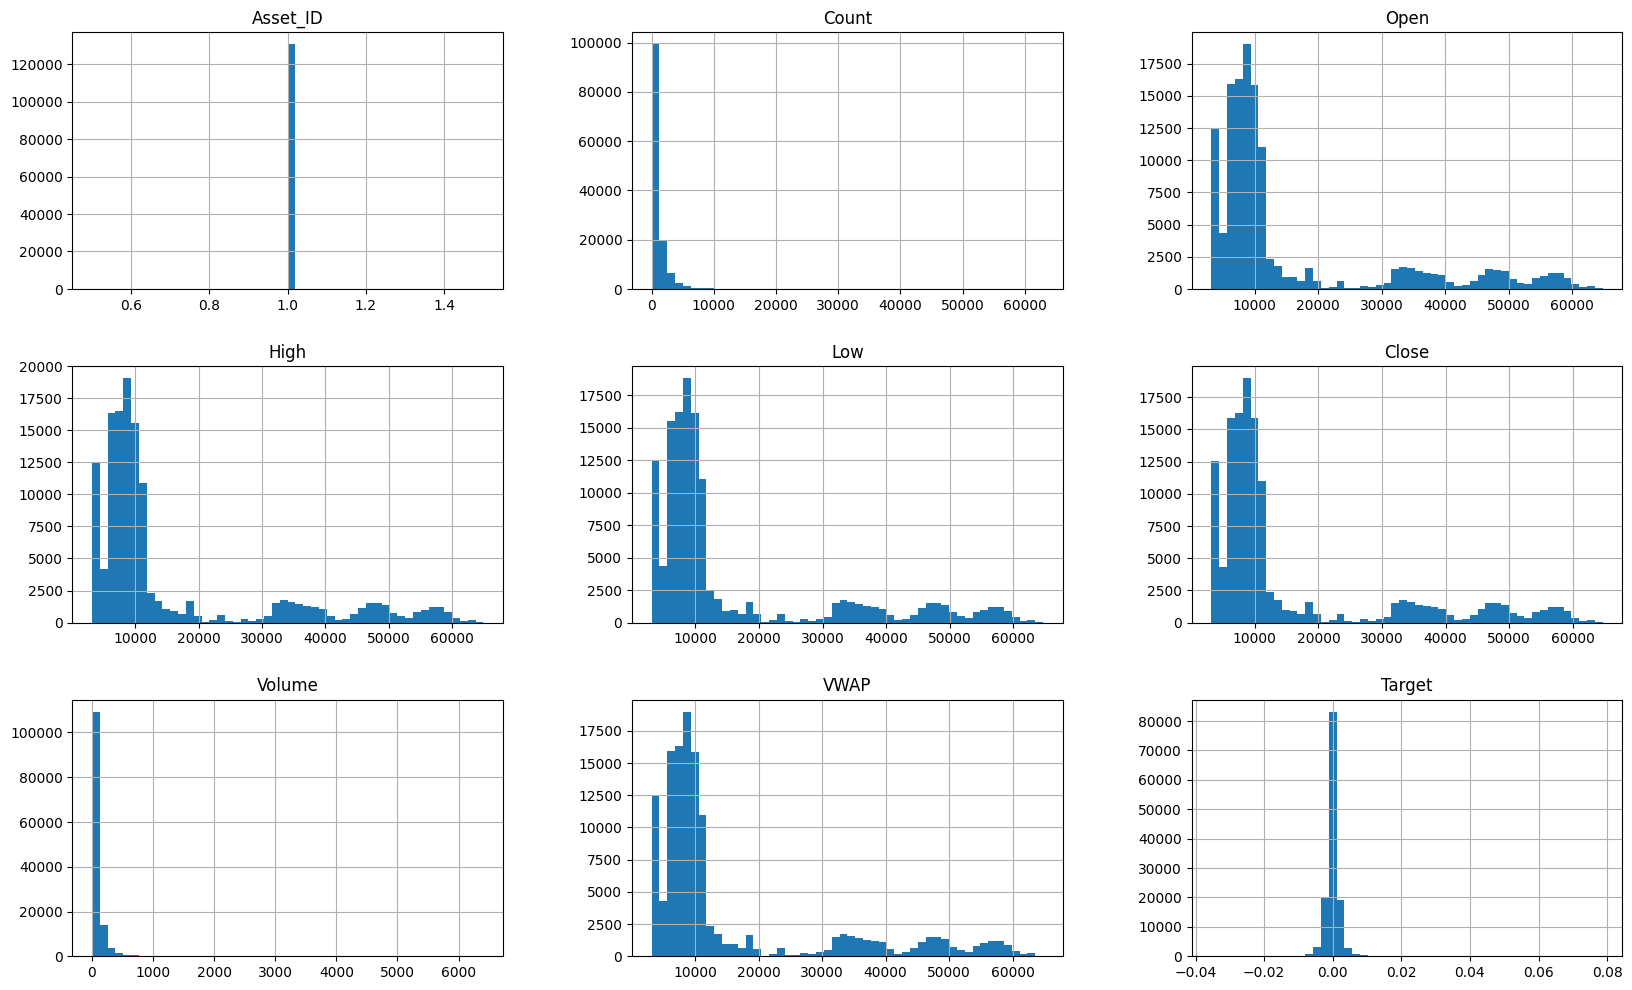

In [52]:
btc_resampled.hist(bins=50, figsize=(20,12))
plt.show()

**Applying log transformation to VWAP & Volume**

In [95]:
btc_resampled['log_vwap'] = np.log(btc_resampled['VWAP'])
btc_resampled['log_vol'] = np.log(btc_resampled['Volume'])
eth_resampled['log_vwap'] = np.log(eth_resampled['VWAP'])
eth_resampled['log_vol'] = np.log(eth_resampled['Volume'])
car_resampled['log_vwap'] = np.log(car_resampled['VWAP'])
car_resampled['log_vol'] = np.log(car_resampled['Volume'])

In [54]:
btc_resampled = btc_resampled[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Target', 'log_vwap', 'log_vol']]
eth_resampled = eth_resampled[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Target', 'log_vwap', 'log_vol']]
car_resampled = car_resampled[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Target', 'log_vwap', 'log_vol']]

## **Train - Validation - Test Split**

In [55]:
df = btc_resampled.copy()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]

val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## **Standardizing Data using moving averages**

In [56]:
import pandas as pd

def standardize_data(df, columns_to_exclude=None, window_size=60):
    if columns_to_exclude is None:
        columns_to_exclude = []

    standardized_df = df.copy()
    for col in df.columns:
        if col not in columns_to_exclude:
            moving_avg = df[col].rolling(window=window_size, min_periods=1).mean()
            moving_std = df[col].rolling(window=window_size, min_periods=1).std()
            standardized_df[col] = (df[col] - moving_avg) / moving_std
    return standardized_df

# Example usage
# Assuming train_df, test_df, val_df are your DataFrames
# Exclude certain columns from standardization
columns_to_exclude = ['Asset_ID','Asset_ID_btc','Asset_ID_eth','Asset_ID_car']

# Standardize train_df
train_df = standardize_data(train_df, columns_to_exclude=columns_to_exclude)
train_df['day'] = train_df.index.day
train_df['week'] = train_df.index.week
train_df['month'] = train_df.index.month
train_df.dropna(inplace=True)

# Use the same moving averages and standard deviations from train_df to standardize test_df and val_df
val_df = standardize_data(val_df, columns_to_exclude=columns_to_exclude)
val_df['day'] = val_df.index.day
val_df['week'] = val_df.index.week
val_df['month'] = val_df.index.month
val_df.dropna(inplace=True)

test_df = standardize_data(test_df, columns_to_exclude=columns_to_exclude)
test_df['day'] = test_df.index.day
test_df['week'] = test_df.index.week
test_df['month'] = test_df.index.month
test_df.dropna(inplace=True)

<ipython-input-56-8dfc2f85ec22>:23: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = train_df.index.week
<ipython-input-56-8dfc2f85ec22>:30: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  val_df['week'] = val_df.index.week
<ipython-input-56-8dfc2f85ec22>:36: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  test_df['week'] = test_

In [57]:
train_df.head()

,Asset_ID,Count,Open,High,Low,Close,Target,log_vwap,log_vol,day,week,month
timestamp,,,,,,,,,,,,
2018-01-01 00:15:00,1,0.707107,-0.707107,-0.707107,-0.707107,-0.707107,0.707107,-0.707107,0.707107,1,1,1
2018-01-01 00:30:00,1,-0.936329,-0.883239,-0.146944,-1.002309,-0.803502,0.290756,-0.853756,-1.071036,1,1,1
2018-01-01 00:45:00,1,-0.026873,-0.783614,-0.082788,-0.131332,-0.329593,-1.010519,-0.583301,0.102401,1,1,1
2018-01-01 01:00:00,1,-1.311350,-1.445940,-0.793736,-1.368060,-1.477722,1.455946,-1.456418,-1.527673,1,1,1
2018-01-01 01:15:00,1,-0.133428,-0.473639,-1.630242,1.538672,-0.574536,-1.688230,-0.643826,-0.026530,1,1,1


**Feature Distribution after standardization**

<ipython-input-58-d708893081ca>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


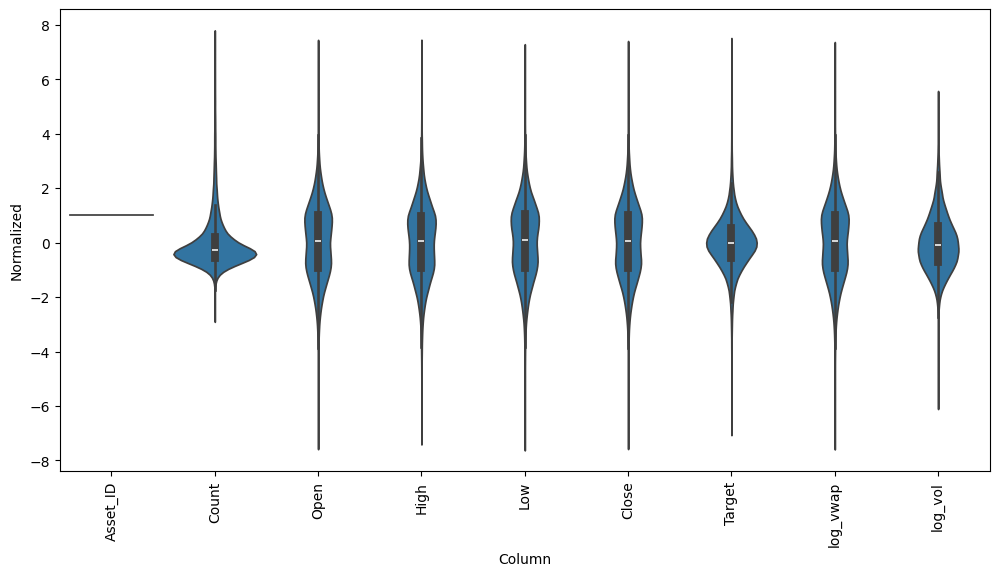

In [58]:
import seaborn as sns
ndf = train_df[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Target','log_vwap', 'log_vol']]
df_std = ndf.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

**Time series sequence generator**

In [59]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    #print('self.input_slice:', self.input_slice)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    #print('self.input_indices:', self.input_indices)

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    #print('self.labels_slice:', self.labels_slice)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    #print('self.label_indices:', self.label_indices)

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

**Example sequence**

In [61]:
w2 = WindowGenerator(input_width=60, label_width=60, shift=1,
                     label_columns=['Target'])
w2

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): ['Target']

**Splitting sequence to labels & target**

In [62]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  #print('inputs:',inputs[0])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [63]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 61, 12)
Inputs shape: (3, 60, 12)
Labels shape: (3, 1, 1)


In [64]:
w2.example = example_inputs, example_labels

**Plotting Function**

In [65]:
def plot(self, model=None, plot_col='Target', max_subplots=3):
  #print('ex: ',self.example)
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  #print('plotcol:',self.column_indices[plot_col])
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    #print('inp_ind:',self.input_indices)
    #print('inp:',inputs[n, :, plot_col_index])
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    #print('label_ind',self.label_indices)
    #print('lab:',labels[n, :, label_col_index])
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#FF9633', s=64)
    #print('inps:',inputs[0])
    if model is not None:
      predictions = model(inputs)
      #print('preds:',len(predictions))

      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#3358FF', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Target')

WindowGenerator.plot = plot

**Sample Plots**

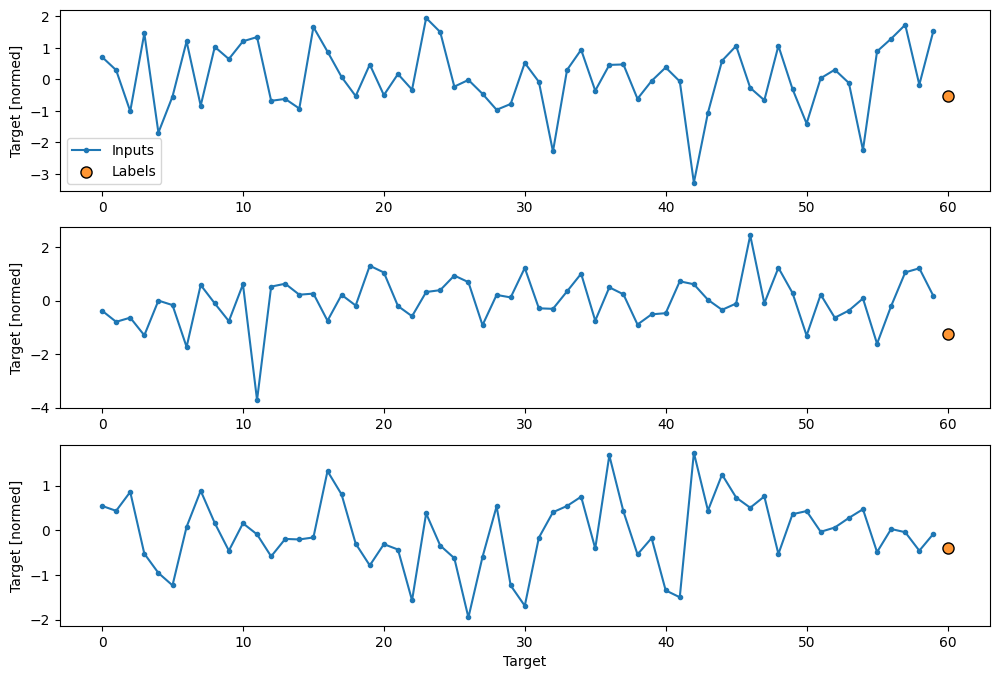

In [66]:
w2.plot()

**Tensorflow Dataset generator**

In [67]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=128,)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [68]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## **Baseline Model - Forward fill**

In [69]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [78]:
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['Target'])

wide_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['Target']

**Baseline Model Compile & Fit Function**

In [79]:
baseline = Baseline(label_index=column_indices['Target'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

204/204 [==============================] - 2s 11ms/step - loss: 2.1279 - mean_absolute_error: 1.0935


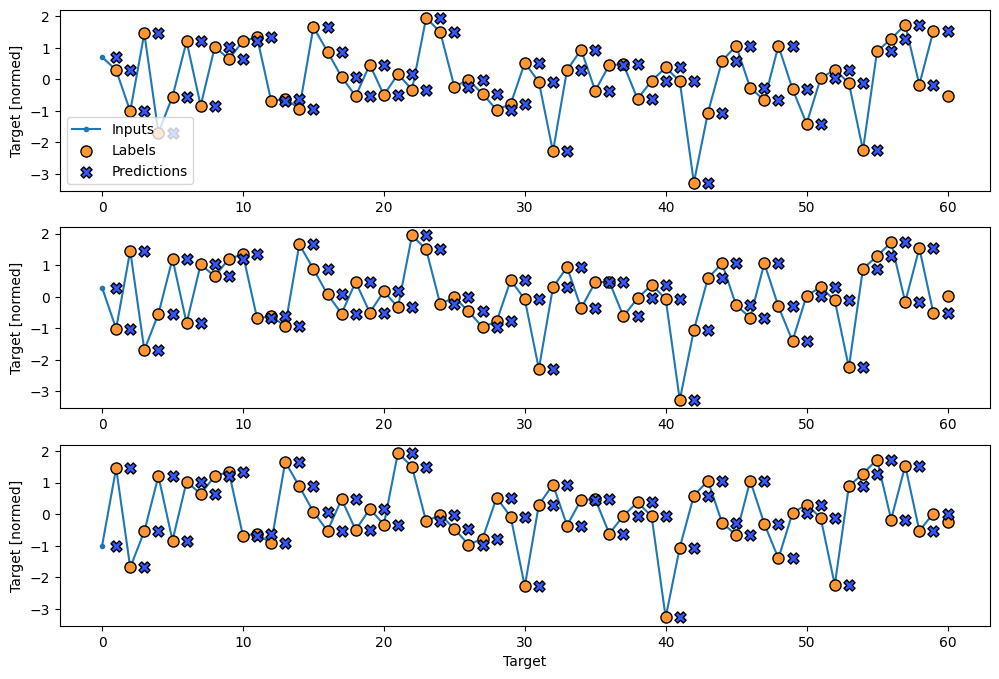

In [80]:
wide_window.plot(baseline)

**Model Compile & Fit Function**

In [81]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

**Stacked LSTM Model - 1**

In [88]:
import tensorflow as tf

# Define the model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with a dropout rate of 0.2
    tf.keras.layers.Dense(units=1)
])

**Checking Input & Output shapes for LSTM**

In [89]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (128, 60, 12)
Output shape: (128, 60, 1)


**Training & Validation of LSTM model**

In [90]:
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
713/713 [==============================] - 250s 345ms/step - loss: 1.0100 - mean_absolute_error: 0.7295 - mean_absolute_percentage_error: 166.6967 - val_loss: 1.0154 - val_mean_absolute_error: 0.7441 - val_mean_absolute_percentage_error: 122.3819
Epoch 2/20
713/713 [==============================] - 325s 456ms/step - loss: 0.9972 - mean_absolute_error: 0.7239 - mean_absolute_percentage_error: 171.6101 - val_loss: 1.0146 - val_mean_absolute_error: 0.7433 - val_mean_absolute_percentage_error: 122.0989
Epoch 3/20
713/713 [==============================] - 273s 383ms/step - loss: 0.9949 - mean_absolute_error: 0.7228 - mean_absolute_percentage_error: 167.6913 - val_loss: 1.0141 - val_mean_absolute_error: 0.7430 - val_mean_absolute_percentage_error: 123.6863
Epoch 4/20
713/713 [==============================] - 275s 385ms/step - loss: 0.9943 - mean_absolute_error: 0.7226 - mean_absolute_percentage_error: 173.0768 - val_loss: 1.0140 - val_mean_absolute_error: 0.7427 - val_mean_abso

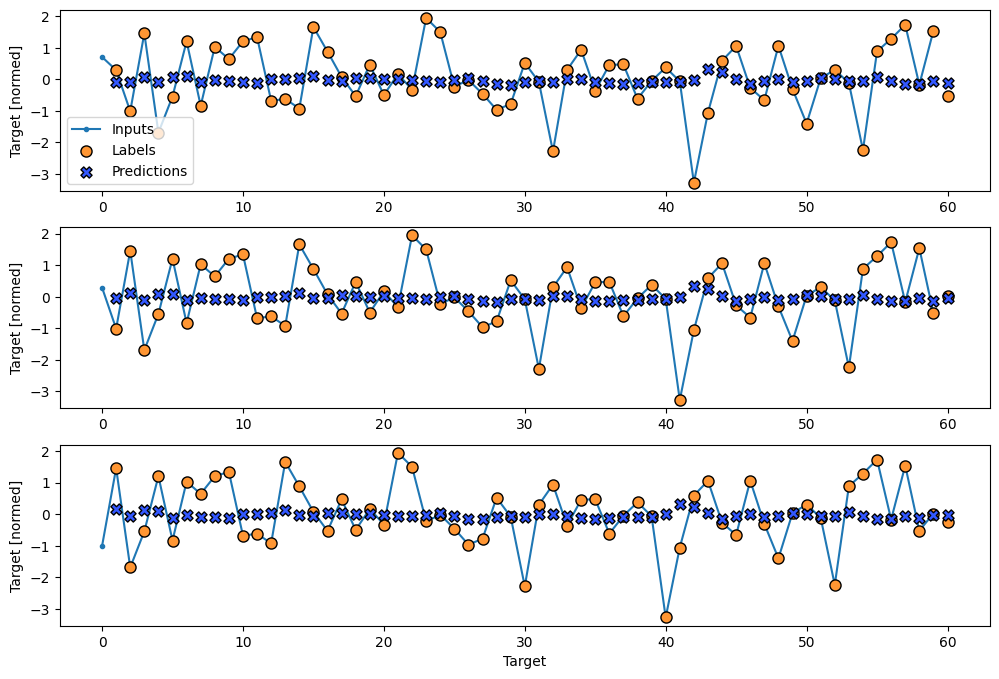

In [91]:
wide_window.plot(lstm_model)